In [17]:
import numpy as np
import math
from catboost import Pool, CatBoostRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
import tqdm

def generate_training_data(n_samples, seed=0):
    np.random.seed(seed)
    _train = []
    _target = []
    for _ in range(n_samples):
        x = np.random.rand()
        y = np.random.rand()
        if ((x-0.5)*(x-0.5) + (y-0.5)*(y-0.5) <= 0.25):
            if ((x-0.5)*(x-0.5) + (y-0.5)*(y-0.5) >= 0.1):
                if not (0.4 <= x <= 0.6) and not (0.4 <= y <= 0.6):
                    _train.append([x, y])
                    _target.append(np.sin(x) + y)
    _train = np.asarray(_train)
    _target = np.asarray(_target)

    return _train, _target
def generate_test_data(n_samples, seed=0):
    np.random.seed(seed)
    _test = []
    _true_target = []
    for _ in range(n_samples):
        x = np.random.rand()
        y = np.random.rand()
        _test.append([x, y])
        _true_target.append(np.sin(x) + y)
    _test = np.asarray(_test)
    _true_target = np.asarray(_true_target)
    return _test, _true_target

# generate train and validation datasets
train, target = generate_training_data(10000)
test, true_func = generate_test_data(10000)

train_pool = [train, target,[]]
val_pool = train_pool

import json 

def GP_DoEverything(_train_pool, _val_pool, cd=None, depth=6, seed=0, iters=1000, lr=0.3, iters_rand=100, sigma=0.3, rs=0.1):
    train_pool = [_train_pool[0], _train_pool[1]]
    val_pool = [_val_pool[0], _val_pool[1]]
    tr_pool = cb.Pool(_train_pool[0], 0.00001*np.random.randn(len(_train_pool[1])), cat_features=cd)
    model = cb.CatBoostRegressor(random_seed=seed * iters_rand + 77 * 123, 
                                      iterations=iters_rand, 
                                      learning_rate=0.00001, 
                                      loss_function='RMSE',
                                      bootstrap_type='No', 
                                      depth=depth,
                                      verbose=False,
                                      leaf_estimation_backtracking="No",
                                      leaf_estimation_method="Gradient",
                                      boost_from_average=False, 
                                      random_strength=1e4,
                                      l2_leaf_reg=0,
                                      score_function="L2",
                                      boosting_type='Plain',
                                      min_data_in_leaf=0,
                                      feature_border_type='Uniform'
    )
    model.fit(tr_pool, use_best_model=False)
    model.save_model("randomtree1.json", format="json", pool=tr_pool)
    with open("randomtree1.json", "r", encoding='utf-8') as f:
        model__ = json.load(f)
        for tree in model__["oblivious_trees"]:
            for ind, (val, weight) in enumerate(zip(tree["leaf_values"], tree["leaf_weights"])):
                    tree["leaf_values"][ind] = np.random.randn() * np.sqrt(len(_train_pool[0])) / np.sqrt(max(1, weight))
        with open("rt1.json", "w") as g:
            json.dump(model__, g)
    model.load_model("rt1.json", format="json")
    s1, b1 = model.get_scale_and_bias()
    model.set_scale_and_bias(s1 * sigma / np.sqrt(iters_rand),  (b1) * sigma / np.sqrt(iters_rand))
    training = cb.Pool(train_pool[0],train_pool[1] - model.predict(train_pool[0]), cat_features=cd) # train_pool[1] - mean_model.predict(train_pool[0]) 
    val = cb.Pool(val_pool[0],val_pool[1] - model.predict(val_pool[0]), cat_features=cd)# val_pool[1] - mean_model.predict(val_pool[0]) 
    model2 = cb.CatBoostRegressor(random_seed=seed * 7 * iters_rand + 3, 
                                  iterations=iters - iters_rand, 
                                  learning_rate=lr, 
                                  loss_function='RMSE',
                                  bootstrap_type='No', 
                                  depth=depth,
                                  verbose=False,
                                  leaf_estimation_backtracking="No",
                                  leaf_estimation_method="Gradient",
                                  boost_from_average=False,
                                  random_strength=rs,
                                  l2_leaf_reg=0,
                                  score_function="L2",
                                  boosting_type='Plain',
                                  min_data_in_leaf=0,
                                  feature_border_type='Uniform'
    )
    model2.fit(training, eval_set=val, use_best_model=False)
    model3 = cb.sum_models([model2, model], weights=[1.0, 1.0])
    return model3


In [18]:
def ensemble_kgb(train_pool, val_pool, cd=None, num_samples=100, lr=0.3):
    ens_preds = []
    for iseed in tqdm.trange(num_samples):
        model4 = GP_DoEverything(train_pool, val_pool, cd=cd, 
                                   seed=123+iseed, sigma=0.1,
                                   iters=1000, iters_rand=100,
                                   lr=lr, rs=0.1, depth=4
        )
        ens_preds.append(model4.predict(test))
    return ens_preds

In [19]:
ens_preds = ensemble_kgb(train_pool, val_pool, cd=[])

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Data Set:


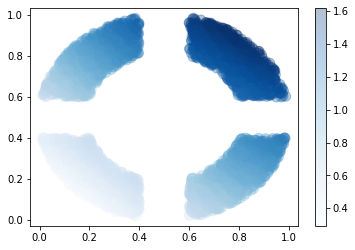

In [28]:
print("Data Set:")            
plt.scatter(*np.transpose(train), c=target, s=100, alpha=0.3, cmap='Blues')   
plt.colorbar()
plt.savefig("data_set.pdf")
plt.show()

Prediction by KGB:


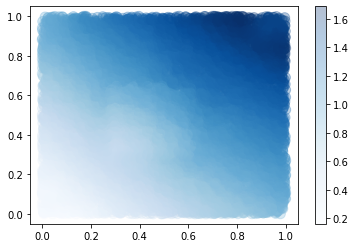

In [25]:
ens_preds = np.asarray(ens_preds)
ens_preds = np.transpose(ens_preds)
preds = np.array([np.mean(x)  for x in ens_preds ]) # average estimated data uncertainty
knowledge = np.array([np.var(x)  for x in ens_preds ]) # estimated knowledge uncertainty
ens_preds = np.transpose(ens_preds)
print("Prediction by KGB:")            
plt.scatter(*np.transpose(test), c=preds, s=100, alpha=0.3, cmap='Blues')   
plt.colorbar()
plt.savefig("kgb_pred.pdf")
plt.show()

Knowledge uncertainty via KGB:


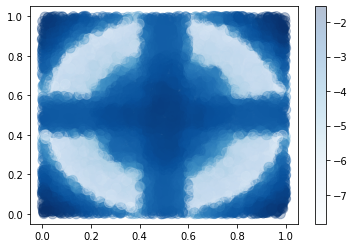

In [27]:
print("Knowledge uncertainty via KGB:")            
plt.scatter(*np.transpose(test), c=np.log(np.sqrt(knowledge)), s=100, alpha=0.3, cmap='Blues')   
plt.colorbar()
plt.savefig("kgb_unc.pdf")
plt.show()